# Features engineer

# Train on rank transform groupby cell line

In [ ]:
import os
import json
import random
import pickle   # ✅ 新增
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
from datetime import datetime

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  EXPERIMENT CONFIGURATION
# ============================================================
EXPERIMENT_DIR = "../results/lgbm/all_rank_features"
TRAIN_PATH = "../preprocessed_data/CAGE-merged/X1_all_rank_features.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/X2_all_rank_features.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
LOG_PATH = os.path.join(EXPERIMENT_DIR, "log.txt")

# ✅ 如果已有舊的 log.txt，直接覆蓋（清空）
with open(LOG_PATH, "w") as f:
    f.write("")  # 或寫入 header，如 "==== New Experiment ====\n"

def log(msg):
    """同時印出並寫入 log.txt"""
    print(msg)
    with open(LOG_PATH, "a") as f:
        f.write(f"{msg}\n")


log(f"🚀 Experiment started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
log(f"Experiment directory: {EXPERIMENT_DIR}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

feature_cols = [c for c in df_train_full.columns if c not in META_COLS]
log(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  K-FOLD DEFINITION
# ============================================================
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

log("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    log(f"Fold {i+1}: {fset}")

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 16,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "deterministic": True,
    "force_row_wise": True,
}

# ============================================================
#                  SAVE CONFIG
# ============================================================
config = {
    "train_path": TRAIN_PATH,
    "val_path": VAL_PATH,
    "seed": SEED,
    "params": params,
    "folds": folds,
    "target_col": TARGET_COL,
}
with open(os.path.join(EXPERIMENT_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

# ============================================================
#                  TRAINING
# ============================================================
results = []
preds_all = []

preds_all = []

for fold_idx, val_chrs in enumerate(folds):
    log(f"\n🚀 Fold {fold_idx+1}/{len(folds)} | Val chromosomes: {val_chrs}")
    fold_dir = os.path.join(EXPERIMENT_DIR, f"fold_{fold_idx+1}")
    os.makedirs(fold_dir, exist_ok=True)

    # Split
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    # ✅ 保留原始 index，方便之後對齊
    df_val = df_val.reset_index().rename(columns={"index": "orig_idx"})

    X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
    X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    # Save model (.pkl)
    model_path = os.path.join(fold_dir, "model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    log(f"💾 Model saved: {model_path}")

    # Predict
    df_val["predicted_gex_rank"] = model.predict(X_val, num_iteration=model.best_iteration)
    df_val["fold_id"] = fold_idx + 1  # optional: fold 來源

    preds_all.append(df_val[["orig_idx", "gene_name", "predicted_gex_rank", "fold_id"]])

    # Evaluate
    overall_spearman = spearmanr(df_val[TARGET_COL], df_val["predicted_gex_rank"])[0]
    log(f"📈 Fold {fold_idx+1} Overall Spearman ρ = {overall_spearman:.4f}")
    log("📊 Per-Chromosome Spearman:")
    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        rho = spearmanr(subdf[TARGET_COL], subdf["predicted_gex_rank"])[0]
        chr_corrs.append({"chr": chrom, "spearman": rho})
        log(f"   {chrom:<6s}: ρ = {rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": overall_spearman,
        "per_chr": chr_corrs
    })

# ============================================================
#                  SAVE PREDICTIONS & SUMMARY
# ============================================================

# ============================================================
# 🔁 合併並依照原始順序還原
# ============================================================
df_preds_all = pd.concat(preds_all, ignore_index=True)
df_preds_all = df_preds_all.sort_values("orig_idx").reset_index(drop=True)

# 驗證對齊
assert len(df_preds_all) == len(df_val_full)
assert (df_preds_all["gene_name"].values == df_val_full["gene_name"].values).all(), \
    "❌ Prediction order mismatch with df_val_full!"

# ✅ 輸出只有 gene_name + predicted_gex_rank
df_preds_all[["gene_name", "predicted_gex_rank"]].to_csv(
    os.path.join(EXPERIMENT_DIR, "predict_val.tsv"), sep="\t", index=False
)
log("💾 Final predictions (aligned) saved (predict_val.tsv)")

# ✅ 全域 Spearman：用原始 df_val_full 的真值 vs 你的預測
overall_val_spearman = spearmanr(
    df_val_full["gex_rank"], 
    df_preds_all["predicted_gex_rank"]
)[0]
log(f"🌍 Overall validation Spearman (aligned) = {overall_val_spearman:.4f}")




summary_fold = pd.DataFrame([
    {"fold": r["fold"], "val_chr": ",".join(r["val_chr"]), "overall_spearman": r["overall_spearman"]}
    for r in results
])

chr_rows = []
for r in results:
    for c in r["per_chr"]:
        chr_rows.append({"fold": r["fold"], "chr": c["chr"], "spearman": c["spearman"]})
summary_chr = pd.DataFrame(chr_rows)

chr_mean = summary_chr.groupby("chr", as_index=False)["spearman"].mean()
chr_mean.rename(columns={"spearman": "mean_spearman"}, inplace=True)

summary_output = summary_fold.merge(chr_mean, how="cross")
summary_output.to_csv(os.path.join(EXPERIMENT_DIR, "summary.tsv"), sep="\t", index=False)

log("💾 Summary saved (summary.tsv)")
log(f"Mean Spearman (across folds): {summary_fold['overall_spearman'].mean():.4f}")
log(f"Overall mean of per-chromosome means: {chr_mean['mean_spearman'].mean():.4f}")

log(f"\n✅ Experiment finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


🔒 Global seed set to 42
🚀 Experiment started at 2025-10-13 21:36:44
Experiment directory: ../results/lgbm/all_rank_features
Feature count: 456
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1/5 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.120455	val's rmse: 0.197202
Early stopping, best iteration is:
[181]	train's rmse: 0.122437	val's rmse: 0.196494
💾 Model saved: ../results/lgbm/all_rank_features/fold_1/model.pkl
[      orig_idx gene_name  predicted_gex_rank  fold_id
0            0   SLC20A1            0.440282        1
1            5      POMC            0.404937        1
2            6      NME2            0.423935        1
3           10    GALNT9            0.321354        1
4 

In [28]:
import os
import json
import pickle
import shap
import pandas as pd
import numpy as np

def summarize_shap_feature_ranking_from_config(experiment_dir, sample_size=None):
    """
    根據 experiment_dir 下的 config.json，自動載入資料與模型，
    為每個 fold 計算 SHAP importance 並彙總排名。
    
    Parameters
    ----------
    experiment_dir : str
        實驗資料夾（需包含 config.json 與 fold_x/model.pkl）
    sample_size : int or None, default=None
        若為 None，則使用整個 validation fold 的資料。
        若指定數字，則從該 fold 抽樣 sample_size 筆資料以加速計算。
    """

    # ============================================================
    # 1️⃣ 讀取設定
    # ============================================================
    config_path = os.path.join(experiment_dir, "config.json")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"❌ config.json not found in {experiment_dir}")

    with open(config_path, "r") as f:
        config = json.load(f)

    train_path = config["train_path"]
    val_path = config["val_path"]
    folds = config["folds"]
    target_col = config["target_col"]

    print(f"📖 Loaded config from: {config_path}")
    print(f"   Train path: {train_path}")
    print(f"   Val path: {val_path}")
    print(f"   # of folds: {len(folds)}")

    # ============================================================
    # 2️⃣ 載入資料
    # ============================================================
    df_train_full = pd.read_csv(train_path, sep="\t")
    df_val_full   = pd.read_csv(val_path, sep="\t")

    META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
                 "TSS_start", "TSS_end", "strand", "gex", target_col]

    feature_cols = [c for c in df_train_full.columns if c not in META_COLS]

    # ============================================================
    # 3️⃣ 逐 fold 計算 SHAP
    # ============================================================
    fold_dirs = sorted(
        [os.path.join(experiment_dir, d) for d in os.listdir(experiment_dir) if d.startswith("fold_")]
    )
    if not fold_dirs:
        raise FileNotFoundError("No fold_* directories found under experiment_dir")

    results = []

    for fold_idx, (fold_path, val_chrs) in enumerate(zip(fold_dirs, folds), start=1):
        model_path = os.path.join(fold_path, "model.pkl")
        if not os.path.exists(model_path):
            print(f"⚠️ Skipping {fold_path}, no model.pkl found.")
            continue

        print(f"\n🧠 Fold {fold_idx}: loading model → {model_path}")
        with open(model_path, "rb") as f:
            model = pickle.load(f)

        # 選擇對應 validation chromosomes
        df_val_fold = df_val_full[df_val_full["chr"].isin(val_chrs)]
        print(f"   Using validation chromosomes: {val_chrs} ({len(df_val_fold)} samples)")

        if len(df_val_fold) == 0:
            print(f"⚠️ Fold {fold_idx} validation set empty, skipping.")
            continue

        # 抽樣或使用全部
        if sample_size is None:
            X_sample = df_val_fold[feature_cols].values
            print(f"   Using full validation fold ({len(X_sample)} samples) for SHAP.")
        else:
            X_sample = df_val_fold[feature_cols].sample(
                min(sample_size, len(df_val_fold)),
                random_state=config.get("seed", 42)
            ).values
            print(f"   Using {len(X_sample)} sampled rows for SHAP (sample_size={sample_size})")

        # SHAP 計算
        explainer = shap.TreeExplainer(
            model,
            feature_perturbation="interventional",
            model_output="raw"
        )
        shap_values = explainer(X_sample, check_additivity=False).values

        # 平均絕對 SHAP 值
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        df_fold = pd.DataFrame({
            "feature": feature_cols,
            f"fold_{fold_idx}_mean_abs_shap": mean_abs_shap
        })
        df_fold[f"fold_{fold_idx}_rank"] = df_fold[f"fold_{fold_idx}_mean_abs_shap"].rank(
            ascending=False, method="min"
        )
        results.append(df_fold)

    # ============================================================
    # 4️⃣ 整合所有 fold 結果
    # ============================================================
    print("\n🧩 Merging results across folds...")
    df_merge = results[0][["feature"]].copy()
    for df_fold in results:
        df_merge = df_merge.merge(df_fold, on="feature", how="outer")

    shap_cols = [c for c in df_merge.columns if c.endswith("_mean_abs_shap")]
    rank_cols = [c for c in df_merge.columns if c.endswith("_rank")]

    df_merge["mean_abs_shap_all"] = df_merge[shap_cols].mean(axis=1)
    df_merge["mean_rank_all"] = df_merge[rank_cols].mean(axis=1)
    df_merge = df_merge.sort_values("mean_rank_all")

    # ============================================================
    # 5️⃣ 儲存結果
    # ============================================================
    out_path = os.path.join(experiment_dir, "shap_feature_summary.tsv")
    df_merge.to_csv(out_path, sep="\t", index=False)
    print(f"\n💾 SHAP summary saved: {out_path}")

    return df_merge


In [29]:
experiment_dir = "../results/lgbm/all_rank_features"

shap_summary = summarize_shap_feature_ranking_from_config(
    experiment_dir,
    # sample_size=2000
)


📖 Loaded config from: ../results/lgbm/all_rank_features/config.json
   Train path: ../preprocessed_data/CAGE-merged/X1_all_rank_features.tsv
   Val path: ../preprocessed_data/CAGE-merged/X2_all_rank_features.tsv
   # of folds: 5

🧠 Fold 1: loading model → ../results/lgbm/all_rank_features/fold_1/model.pkl
   Using validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22'] (4641 samples)
   Using full validation fold (4641 samples) for SHAP.


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(



🧠 Fold 2: loading model → ../results/lgbm/all_rank_features/fold_2/model.pkl
   Using validation chromosomes: ['chr3', 'chr8', 'chr13', 'chr18'] (2258 samples)
   Using full validation fold (2258 samples) for SHAP.

🧠 Fold 3: loading model → ../results/lgbm/all_rank_features/fold_3/model.pkl
   Using validation chromosomes: ['chr4', 'chr9', 'chr14', 'chr19'] (3453 samples)
   Using full validation fold (3453 samples) for SHAP.

🧠 Fold 4: loading model → ../results/lgbm/all_rank_features/fold_4/model.pkl
   Using validation chromosomes: ['chr5', 'chr10', 'chr15', 'chr20'] (2652 samples)
   Using full validation fold (2652 samples) for SHAP.


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(
/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(
/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background da


🧠 Fold 5: loading model → ../results/lgbm/all_rank_features/fold_5/model.pkl
   Using validation chromosomes: ['chr6', 'chr11', 'chr16', 'chr21'] (3280 samples)
   Using full validation fold (3280 samples) for SHAP.


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(



🧩 Merging results across folds...

💾 SHAP summary saved: ../results/lgbm/all_rank_features/shap_feature_summary.tsv


In [ ]:
import os
import json
import random
import pickle   # ✅ 新增
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
from datetime import datetime

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  EXPERIMENT CONFIGURATION
# ============================================================
EXPERIMENT_DIR = "../results/lgbm/top260_features"
TRAIN_PATH = "../preprocessed_data/CAGE-merged/X1_all_rank_features.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/X2_all_rank_features.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"
feature_cols = shap_summary['feature'][:260]

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
LOG_PATH = os.path.join(EXPERIMENT_DIR, "log.txt")

# ✅ 如果已有舊的 log.txt，直接覆蓋（清空）
with open(LOG_PATH, "w") as f:
    f.write("")  # 或寫入 header，如 "==== New Experiment ====\n"

def log(msg):
    """同時印出並寫入 log.txt"""
    print(msg)
    with open(LOG_PATH, "a") as f:
        f.write(f"{msg}\n")


log(f"🚀 Experiment started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
log(f"Experiment directory: {EXPERIMENT_DIR}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

log(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  K-FOLD DEFINITION
# ============================================================
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

log("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    log(f"Fold {i+1}: {fset}")

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 16,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "deterministic": True,
    "force_row_wise": True,
}

# ============================================================
#                  SAVE CONFIG
# ============================================================
config = {
    "train_path": TRAIN_PATH,
    "val_path": VAL_PATH,
    "seed": SEED,
    "params": params,
    "folds": folds,
    "target_col": TARGET_COL,
}
with open(os.path.join(EXPERIMENT_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

# ============================================================
#                  TRAINING
# ============================================================
results = []
preds_all = []

preds_all = []

for fold_idx, val_chrs in enumerate(folds):
    log(f"\n🚀 Fold {fold_idx+1}/{len(folds)} | Val chromosomes: {val_chrs}")
    fold_dir = os.path.join(EXPERIMENT_DIR, f"fold_{fold_idx+1}")
    os.makedirs(fold_dir, exist_ok=True)

    # Split
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    # ✅ 保留原始 index，方便之後對齊
    df_val = df_val.reset_index().rename(columns={"index": "orig_idx"})

    X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
    X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    # Save model (.pkl)
    model_path = os.path.join(fold_dir, "model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    log(f"💾 Model saved: {model_path}")

    # Predict
    df_val["predicted_gex_rank"] = model.predict(X_val, num_iteration=model.best_iteration)
    df_val["fold_id"] = fold_idx + 1  # optional: fold 來源

    preds_all.append(df_val[["orig_idx", "gene_name", "predicted_gex_rank", "fold_id"]])

    # Evaluate
    overall_spearman = spearmanr(df_val[TARGET_COL], df_val["predicted_gex_rank"])[0]
    log(f"📈 Fold {fold_idx+1} Overall Spearman ρ = {overall_spearman:.4f}")
    log("📊 Per-Chromosome Spearman:")
    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        rho = spearmanr(subdf[TARGET_COL], subdf["predicted_gex_rank"])[0]
        chr_corrs.append({"chr": chrom, "spearman": rho})
        log(f"   {chrom:<6s}: ρ = {rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": overall_spearman,
        "per_chr": chr_corrs
    })

# ============================================================
#                  SAVE PREDICTIONS & SUMMARY
# ============================================================

# ============================================================
# 🔁 合併並依照原始順序還原
# ============================================================
df_preds_all = pd.concat(preds_all, ignore_index=True)
df_preds_all = df_preds_all.sort_values("orig_idx").reset_index(drop=True)

# 驗證對齊
assert len(df_preds_all) == len(df_val_full)
assert (df_preds_all["gene_name"].values == df_val_full["gene_name"].values).all(), \
    "❌ Prediction order mismatch with df_val_full!"

# ✅ 輸出只有 gene_name + predicted_gex_rank
df_preds_all[["gene_name", "predicted_gex_rank"]].to_csv(
    os.path.join(EXPERIMENT_DIR, "predict_val.tsv"), sep="\t", index=False
)
log("💾 Final predictions (aligned) saved (predict_val.tsv)")

# ✅ 全域 Spearman：用原始 df_val_full 的真值 vs 你的預測
overall_val_spearman = spearmanr(
    df_val_full["gex_rank"], 
    df_preds_all["predicted_gex_rank"]
)[0]
log(f"🌍 Overall validation Spearman (aligned) = {overall_val_spearman:.4f}")




summary_fold = pd.DataFrame([
    {"fold": r["fold"], "val_chr": ",".join(r["val_chr"]), "overall_spearman": r["overall_spearman"]}
    for r in results
])

chr_rows = []
for r in results:
    for c in r["per_chr"]:
        chr_rows.append({"fold": r["fold"], "chr": c["chr"], "spearman": c["spearman"]})
summary_chr = pd.DataFrame(chr_rows)

chr_mean = summary_chr.groupby("chr", as_index=False)["spearman"].mean()
chr_mean.rename(columns={"spearman": "mean_spearman"}, inplace=True)

summary_output = summary_fold.merge(chr_mean, how="cross")
summary_output.to_csv(os.path.join(EXPERIMENT_DIR, "summary.tsv"), sep="\t", index=False)

log("💾 Summary saved (summary.tsv)")
log(f"Mean Spearman (across folds): {summary_fold['overall_spearman'].mean():.4f}")
log(f"Overall mean of per-chromosome means: {chr_mean['mean_spearman'].mean():.4f}")

log(f"\n✅ Experiment finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


🔒 Global seed set to 42
🚀 Experiment started at 2025-10-13 22:07:07
Experiment directory: ../results/lgbm/top260_features
Feature count: 260
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1/5 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds


In [13]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  CONFIGURATION
# ============================================================
TRAIN_PATH = "../preprocessed_data/CAGE-merged/X1_all_rank_features.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/X2_all_rank_features.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

# Chromosomes (autosomes 2–22)
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

print("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    print(f"Fold {i+1}: {fset}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")
feature_cols = [c for c in df_train_full.columns if c not in META_COLS]
print(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 16,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "deterministic": True,   # reproducibility flag (>= LGBM 4.0)
    "force_row_wise": True,  # prevent threading non-determinism
}

# ============================================================
#                  CROSS-CHROMOSOME TRAINING
# ============================================================
results = []

for fold_idx, val_chrs in enumerate(folds):
    print(f"\n🚀 Fold {fold_idx+1} | Val chromosomes: {val_chrs}")
    
    # -----------------------------
    # Split by chromosome
    # -----------------------------
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    # -----------------------------
    # Prepare X, y
    # -----------------------------
    X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
    X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

    # -----------------------------
    # LightGBM Dataset
    # -----------------------------
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # -----------------------------
    # Train model
    # -----------------------------
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    # -----------------------------
    # Predictions
    # -----------------------------
    df_val["pred"] = model.predict(X_val, num_iteration=model.best_iteration)

    # -----------------------------
    # Evaluate Spearman correlation
    # -----------------------------
    overall_spearman = spearmanr(df_val[TARGET_COL], df_val["pred"])[0]
    print(f"\n📈 Fold {fold_idx+1} Overall Spearman ρ = {overall_spearman:.4f}")
    print("📊 Per-Chromosome Spearman Correlation:")

    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        rho = spearmanr(subdf[TARGET_COL], subdf["pred"])[0]
        chr_corrs.append({"chr": chrom, "spearman": rho})
        print(f"   {chrom:<6s}: ρ = {rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": overall_spearman,
        "per_chr": chr_corrs
    })

# ============================================================
#                  SUMMARY
# ============================================================
summary_fold = pd.DataFrame([
    {"fold": r["fold"], "val_chr": ",".join(r["val_chr"]), "overall_spearman": r["overall_spearman"]}
    for r in results
])

# --- 收集所有 per-chr spearman ---
chr_rows = []
for r in results:
    for c in r["per_chr"]:
        chr_rows.append({"fold": r["fold"], "chr": c["chr"], "spearman": c["spearman"]})
summary_chr = pd.DataFrame(chr_rows)

# --- 計算每個 chr 的平均 ---
chr_mean = summary_chr.groupby("chr", as_index=False)["spearman"].mean().rename(columns={"spearman": "mean_spearman"})

# ============================================================
#                  PRINT RESULTS
# ============================================================
print("\n===== Cross-Chromosome Fold Summary =====")
print(summary_fold)
print(f"\nMean Spearman (across folds): {summary_fold['overall_spearman'].mean():.4f}")

print("\n===== Per-Chromosome Mean Spearman =====")
print(chr_mean.sort_values("mean_spearman", ascending=False))
print(f"\nOverall mean of per-chromosome means: {chr_mean['mean_spearman'].mean():.4f}")


🔒 Global seed set to 42
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']
Feature count: 456

🚀 Fold 1 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.120455	val's rmse: 0.197202
Early stopping, best iteration is:
[181]	train's rmse: 0.122437	val's rmse: 0.196494

📈 Fold 1 Overall Spearman ρ = 0.7468
📊 Per-Chromosome Spearman Correlation:
   chr12 : ρ = 0.7557
   chr17 : ρ = 0.7452
   chr2  : ρ = 0.7338
   chr22 : ρ = 0.7400
   chr7  : ρ = 0.7587

🚀 Fold 2 | Val chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	train's rmse: 0.1379	val's rmse: 0.197077

📈 Fold 2 Overall Spearman ρ = 0.7545
📊 Per-Ch

In [5]:
import shap

def compute_shap_values(fitted_model, X_sample, max_display=30):
    """
    Compute SHAP values for any tree-based or linear model.
    - fitted_model: already trained model (LGBM, XGB, CatBoost, etc.)
    - X_sample: subset of data for SHAP computation (建議隨機取樣以節省時間)
    """
    print(f"\n⚡ Running SHAP for model: {fitted_model.__class__.__name__}")
    
    # --- 建立 explainer ---
    explainer = shap.Explainer(fitted_model, X_sample)
    
    # --- 計算 SHAP 值 ---
    shap_values = explainer(X_sample)
    
    # --- 可視化總體重要性 ---
    shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=max_display)
    
    # --- 可視化每個 feature 的分佈（更細緻）---
    shap.summary_plot(shap_values, X_sample, max_display=max_display)
    
    return shap_values, explainer


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pandas as pd
from lightgbm import LGBMRegressor

# 假設這是你最後訓練的模型與資料
df_train = df_train_full.copy()
feature_cols = [c for c in df_train.columns if c not in META_COLS]

# 訓練一個簡單模型（或用你的 run_cross_chr_cv 結果）
model = LGBMRegressor(
    objective="regression",
    learning_rate=0.05,
    num_leaves=64,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42
)
model.fit(df_train[feature_cols], df_train["gex_rank"])

# --- 取樣一部分資料做 SHAP（太大會很慢）---
X_sample = df_train[feature_cols].sample(2000, random_state=42)

# --- 計算 SHAP 值 ---
shap_values, explainer = compute_shap_values(model, X_sample)


NameError: name 'compute_shap_values' is not defined

In [7]:
import shap

explainer = shap.TreeExplainer(fitted_model, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_sample.values)  # 用 numpy 陣列加速


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_82902/1723564687.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=50)


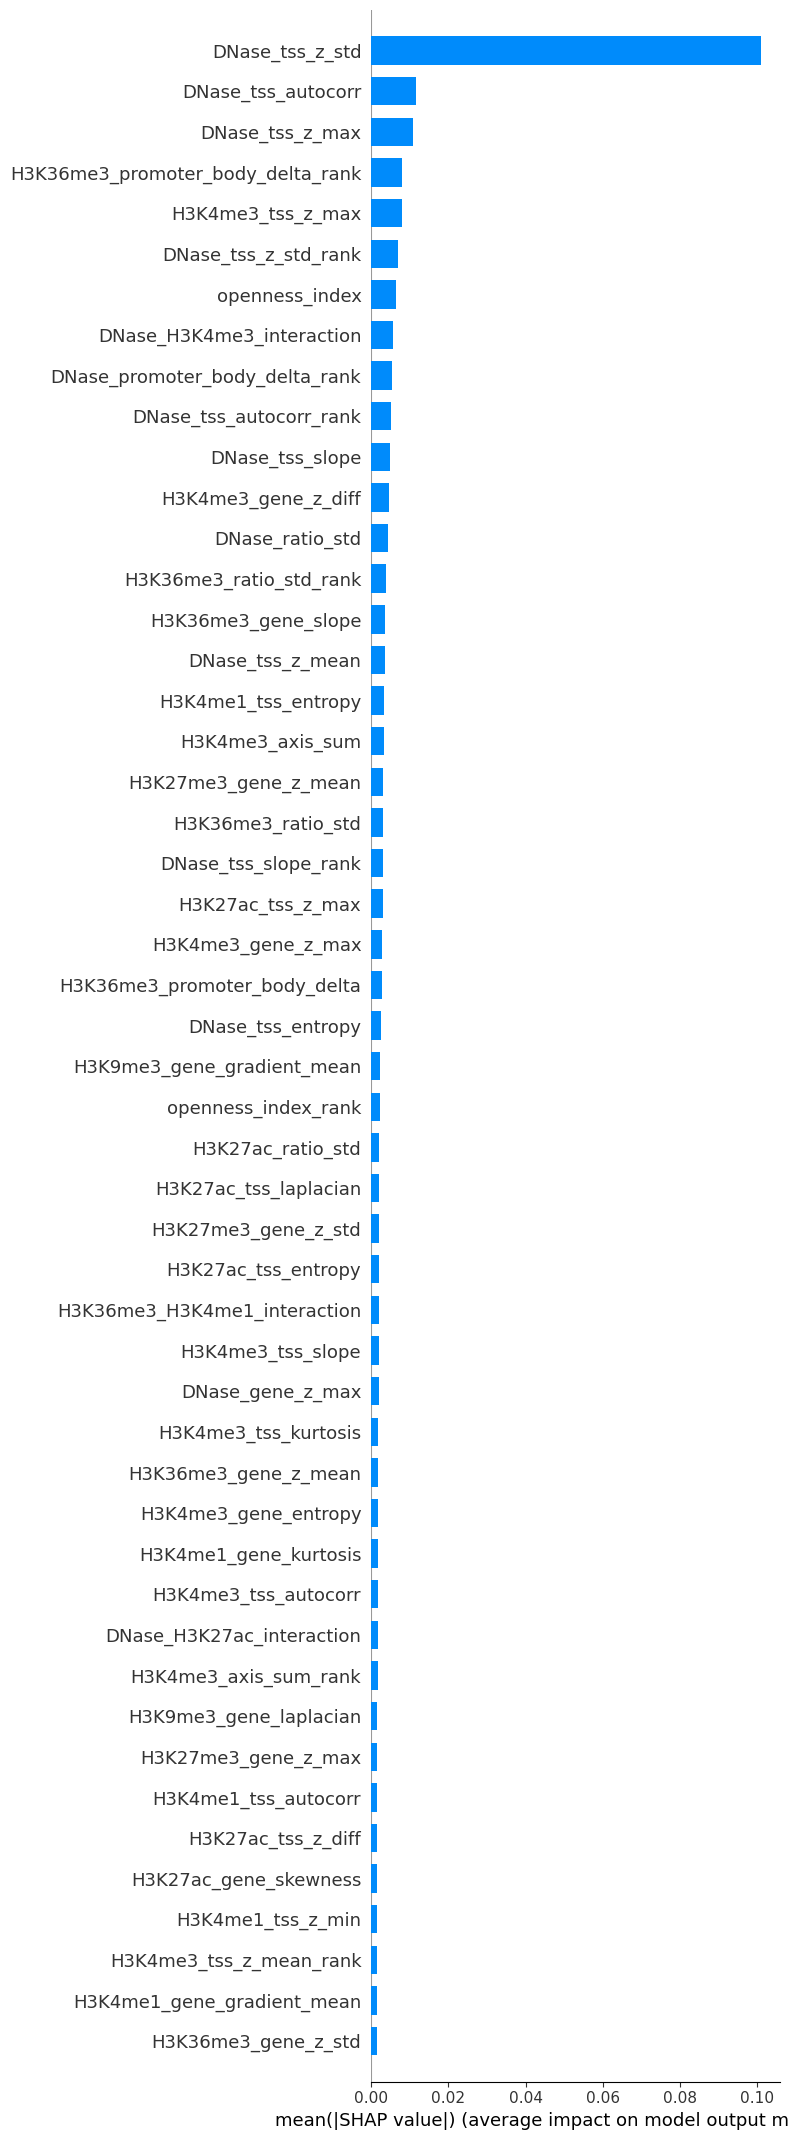

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_82902/1723564687.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, max_display=50)


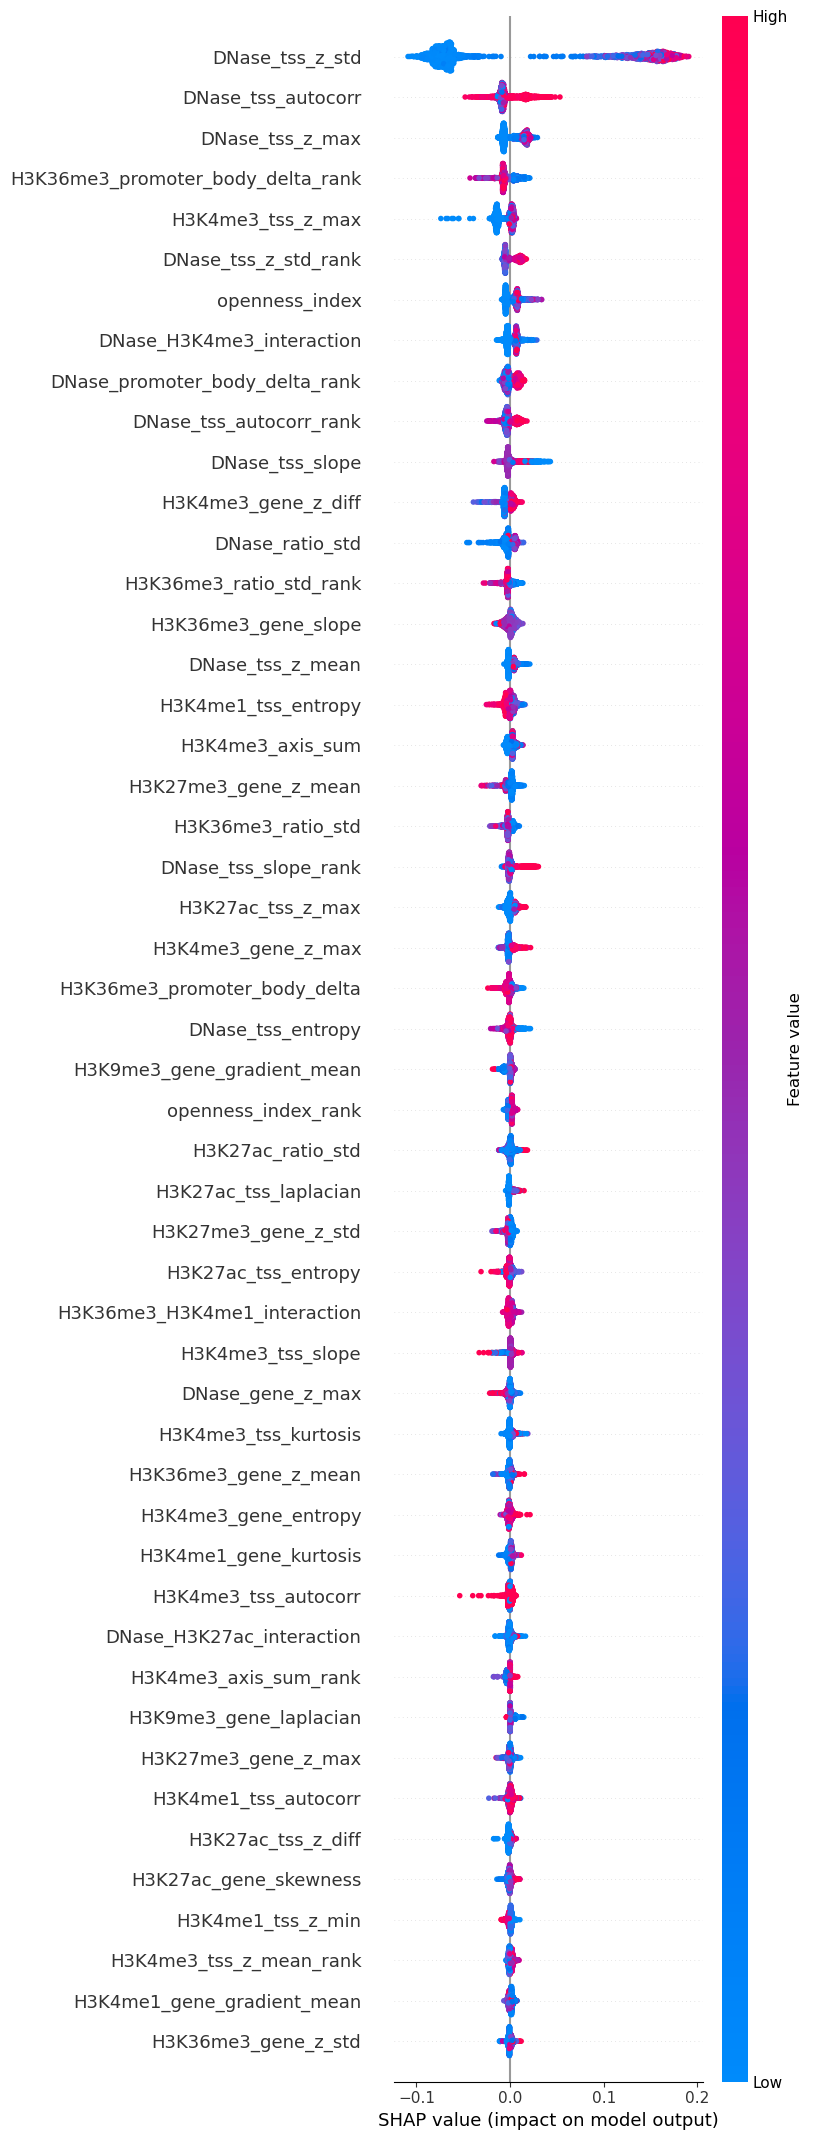

In [9]:

    # --- 可視化總體重要性 ---
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=50)
    
    # --- 可視化每個 feature 的分佈（更細緻）---
shap.summary_plot(shap_values, X_sample, max_display=50)
    


⚡ Running SHAP for model: LGBMRegressor


100%|===================| 1994/2000 [01:26<00:00]        /var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_82902/3788841345.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=max_display)


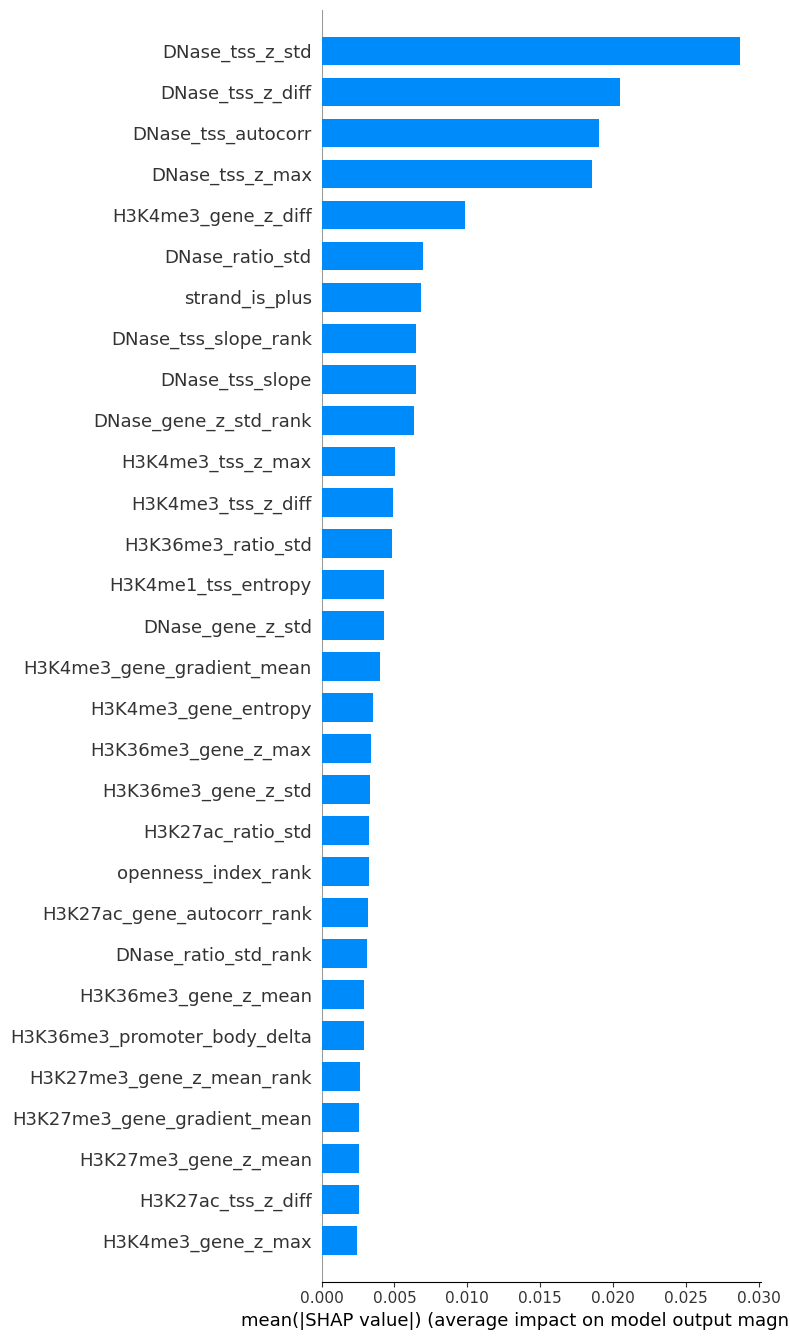

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_82902/3788841345.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, max_display=max_display)


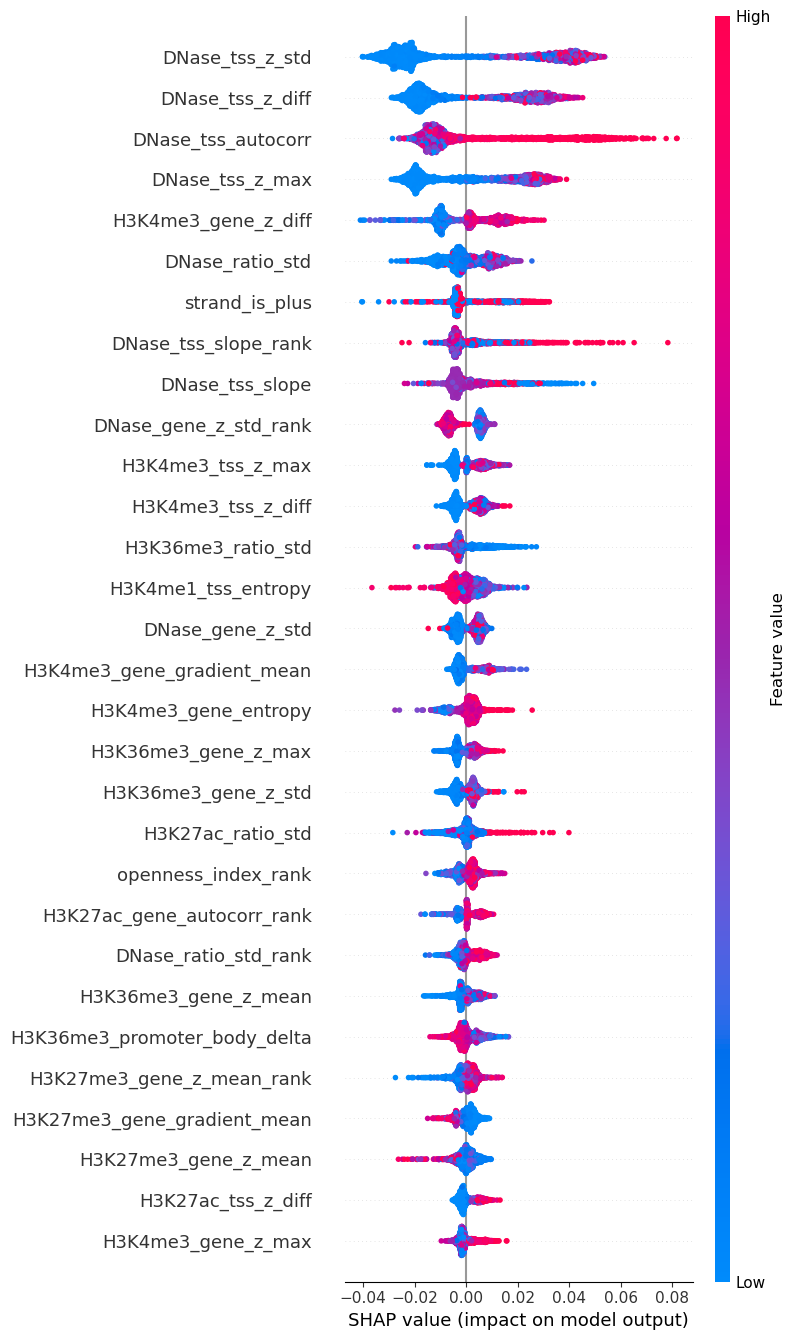

In [6]:
shap_values, explainer = compute_shap_values(model, X_sample)


# Train on leave one chr out method on X1 -> X2, X2 -> X1

In [15]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  CONFIGURATION
# ============================================================
DATA_DIR = "../preprocessed_data/CAGE-merged"
META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"
chromosomes = [f"chr{i}" for i in range(2, 23)]

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "deterministic": True,
    "force_row_wise": True,
}

# ============================================================
#                  FUNCTION: LOCO EXPERIMENT
# ============================================================
def run_loco(train_name, val_name):
    """Perform Leave-One-Chromosome-Out CV: train on `train_name`, validate on `val_name`"""
    print(f"\n==============================")
    print(f" 🔁 LOCO: {train_name} → {val_name}")
    print(f"==============================")

    df_train_full = pd.read_csv(f"{DATA_DIR}/{train_name}_all_rank_features.tsv", sep="\t")
    df_val_full   = pd.read_csv(f"{DATA_DIR}/{val_name}_all_rank_features.tsv", sep="\t")
    feature_cols = [c for c in df_train_full.columns if c not in META_COLS]

    results = []

    # ---------------- LOCO LOOP ----------------
    for chrom_val in chromosomes:
        print(f"\n🚀 Leave-One-Chromosome-Out: {chrom_val}")

        train_chrs = [c for c in chromosomes if c != chrom_val]
        df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
        df_val   = df_val_full[df_val_full["chr"] == chrom_val].copy()

        X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
        X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dtrain, dval],
            valid_names=["train", "val"],
            num_boost_round=2000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=200)
            ],
        )

        df_val["pred"] = model.predict(X_val, num_iteration=model.best_iteration)
        rho = spearmanr(df_val[TARGET_COL], df_val["pred"])[0]
        print(f"📈 {chrom_val} Spearman ρ = {rho:.4f}")

        results.append({"chr": chrom_val, "spearman": rho})

    # ---------------- LOCO SUMMARY ----------------
    summary_loco = pd.DataFrame(results)
    mean_loco = summary_loco["spearman"].mean()
    print(f"\nMean Spearman (LOCO {train_name}→{val_name}): {mean_loco:.4f}")

    # ---------------- Full Model Baseline ----------------
    print("\n🏋️ Training Full Model (all chr)...")
    X_train_full, y_train_full = df_train_full[feature_cols], df_train_full[TARGET_COL]
    X_val_full, y_val_full     = df_val_full[feature_cols], df_val_full[TARGET_COL]

    dtrain_full = lgb.Dataset(X_train_full, label=y_train_full)
    dval_full   = lgb.Dataset(X_val_full, label=y_val_full, reference=dtrain_full)

    full_model = lgb.train(
        params,
        dtrain_full,
        valid_sets=[dtrain_full, dval_full],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    df_val_full["pred_full"] = full_model.predict(X_val_full, num_iteration=full_model.best_iteration)
    rho_full = spearmanr(df_val_full[TARGET_COL], df_val_full["pred_full"])[0]
    print(f"\n🌍 Full model ({train_name}→{val_name}) Spearman ρ = {rho_full:.4f}")

    # ---------------- Comparison ----------------
    summary_loco["direction"] = f"{train_name}→{val_name}"
    summary_loco["full_model_rho"] = rho_full
    summary_loco["delta_vs_full"] = summary_loco["spearman"] - rho_full

    print("\n===== LOCO vs Full Model Comparison =====")
    print(summary_loco.sort_values("delta_vs_full", ascending=False))
    print(f"\nAverage Δ(LOCO − Full): {summary_loco['delta_vs_full'].mean():.4f}")

    return summary_loco


# ============================================================
#                  RUN BOTH DIRECTIONS
# ============================================================
summary_X1_to_X2 = run_loco("X1", "X2")
summary_X2_to_X1 = run_loco("X2", "X1")

# ============================================================
#                  COMBINED SUMMARY
# ============================================================
summary_all = pd.concat([summary_X1_to_X2, summary_X2_to_X1], ignore_index=True)
print("\n===== Combined LOCO Summary =====")
print(summary_all)

# Save results (optional)
summary_all.to_csv("summary_LOCO_X1X2_comparison.tsv", sep="\t", index=False)

# ============================================================
#                  GLOBAL SUMMARY STATS
# ============================================================
print("\n📊 Mean Spearman by direction:")
print(summary_all.groupby("direction")["spearman"].mean())

print("\n📊 Mean Δ(LOCO − Full):")
print(summary_all.groupby("direction")["delta_vs_full"].mean())


🔒 Global seed set to 42

 🔁 LOCO: X1 → X2

🚀 Leave-One-Chromosome-Out: chr2
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.0796673	val's rmse: 0.206367
Early stopping, best iteration is:
[114]	train's rmse: 0.099182	val's rmse: 0.205459
📈 chr2 Spearman ρ = 0.7228

🚀 Leave-One-Chromosome-Out: chr3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	train's rmse: 0.106023	val's rmse: 0.205065
📈 chr3 Spearman ρ = 0.7405

🚀 Leave-One-Chromosome-Out: chr4
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.0818229	val's rmse: 0.1918
Early stopping, best iteration is:
[105]	train's rmse: 0.103672	val's rmse: 0.188282
📈 chr4 Spearman ρ = 0.7589

🚀 Leave-One-Chromosome-Out: chr5
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.0807501	val's rmse: 0.217726
Early stopping, best iteration is:
[159]	train's rmse: 0.0890291	val's rmse: 0.214984
📈 

# mix X1, X2 predict leave chr

In [16]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  CONFIGURATION
# ============================================================
X1_PATH = "../preprocessed_data/CAGE-merged/X1_features.tsv"
X2_PATH = "../preprocessed_data/CAGE-merged/X2_features.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

# Chromosomes (autosomes 2–22)
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]  # 五折，每折約4條chr
print("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    print(f"Fold {i+1}: {fset}")

# ============================================================
#                  DATA LOADING & MERGING
# ============================================================
df_X1 = pd.read_csv(X1_PATH, sep="\t")
df_X2 = pd.read_csv(X2_PATH, sep="\t")

# 加入 cell line label 方便日後分析
df_X1["cell_line"] = "X1"
df_X2["cell_line"] = "X2"

# 合併成完整 dataset
df_full = pd.concat([df_X1, df_X2], ignore_index=True)
feature_cols = [c for c in df_full.columns if c not in META_COLS + ["cell_line"]]

print(f"Combined data shape: {df_full.shape}")
print(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "deterministic": True,
    "force_row_wise": True,
}

# ============================================================
#                  CHROMOSOME-BASED K-FOLD CV
# ============================================================
results = []

for fold_idx, val_chrs in enumerate(folds):
    print(f"\n🚀 Fold {fold_idx+1} | Val chromosomes: {val_chrs}")

    # -----------------------------
    # Split by chromosome
    # -----------------------------
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_full[df_full["chr"].isin(train_chrs)].copy()
    df_val   = df_full[df_full["chr"].isin(val_chrs)].copy()

    # -----------------------------
    # Prepare X, y
    # -----------------------------
    X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
    X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

    # -----------------------------
    # LightGBM Dataset
    # -----------------------------
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # -----------------------------
    # Train model
    # -----------------------------
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    # -----------------------------
    # Predictions
    # -----------------------------
    df_val["pred"] = model.predict(X_val, num_iteration=model.best_iteration)

    # -----------------------------
    # Evaluate Spearman correlation
    # -----------------------------
    overall_spearman = spearmanr(df_val[TARGET_COL], df_val["pred"])[0]
    print(f"\n📈 Fold {fold_idx+1} Overall Spearman ρ = {overall_spearman:.4f}")

    # ---- per-chr correlation ----
    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        rho = spearmanr(subdf[TARGET_COL], subdf["pred"])[0]
        chr_corrs.append({"chr": chrom, "spearman": rho})
        print(f"   {chrom:<6s}: ρ = {rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": overall_spearman,
        "per_chr": chr_corrs
    })

# ============================================================
#                  SUMMARY
# ============================================================
summary_fold = pd.DataFrame([
    {"fold": r["fold"], "val_chr": ",".join(r["val_chr"]), "overall_spearman": r["overall_spearman"]}
    for r in results
])

# --- 收集所有 per-chr spearman ---
chr_rows = []
for r in results:
    for c in r["per_chr"]:
        chr_rows.append({"fold": r["fold"], "chr": c["chr"], "spearman": c["spearman"]})
summary_chr = pd.DataFrame(chr_rows)

# --- 計算每個 chr 的平均 ---
chr_mean = summary_chr.groupby("chr", as_index=False)["spearman"].mean().rename(columns={"spearman": "mean_spearman"})

# ============================================================
#                  PRINT RESULTS
# ============================================================
print("\n===== Cross-Chromosome Fold Summary =====")
print(summary_fold)
print(f"\nMean Spearman (across folds): {summary_fold['overall_spearman'].mean():.4f}")

print("\n===== Per-Chromosome Mean Spearman =====")
print(chr_mean.sort_values("mean_spearman", ascending=False))
print(f"\nOverall mean of per-chromosome means: {chr_mean['mean_spearman'].mean():.4f}")


🔒 Global seed set to 42
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']
Combined data shape: (32568, 466)
Feature count: 456

🚀 Fold 1 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.0968828	val's rmse: 0.148716
Early stopping, best iteration is:
[253]	train's rmse: 0.0883764	val's rmse: 0.148628

📈 Fold 1 Overall Spearman ρ = 0.7623
   chr12 : ρ = 0.7963
   chr17 : ρ = 0.7598
   chr2  : ρ = 0.7719
   chr22 : ρ = 0.7671
   chr7  : ρ = 0.7796

🚀 Fold 2 | Val chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.10283	val's rmse: 0.148603
Early stopping, best iteration is:
[138]	train's rmse: 0.113515	val's rmse: 0.1484